# Voxel-level Simulations
This notebook simulates a single fibre and crossing fibre voxel-level configuration to validate LoRE-SD. Every configuration will be tested at multiple signal-to-noise ratios (SNR) to evaluate the robustness of the method.

Some of this code makes use of the MRtrix3 software. Please make sure to have it installed and available in your PATH.

In [1]:
# Add the source directory to the path
import sys
sys.path.append('/home/sleyse4/repos/LoRE_SD/src')


In [2]:
import os
import subprocess
import shutil

import numpy as np
import matplotlib.pyplot as plt

from utils import varia
from utils import SphericalHarmonics as sh

from simulations import simulation
from optimisation import optimise
from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

In [3]:
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

## Constants

In [4]:
lmax = 8

grad = varia.create_gradient_table([0, 1000, 2000], [2, 128, 128])
bvals = np.unique(np.round(grad[...,-1], -2))

Q = optimise.get_transformation_matrix(300, lmax)

varia.pretty_print_gradient_table(grad)

# Multiprocessing reduces the time to run the simulations
cores = 10

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 1.4142135623730949
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.822908676671
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.712611588158
dirgen: [  . ] Optimising directions up to power 1 (10 restarts)...

b-value   |   count   
----------------------
    0     |   2
 1000     |   128
 2000     |   128


dirgen: [done] Optimising directions up to power 1 (10 restarts)
dirgen: final energy = 85866.842800106169


In [5]:
# LoRE-SD Parameters
reg = 1e-3

axial_diffusivities = np.linspace(0, 4e-3, 10)
radial_diffusivities = np.linspace(0, 4e-3, 10)

gaussians = optimise.get_gaussians(axial_diffusivities, radial_diffusivities, bvals, lmax)

## Simulated Configurations
The following fibre configurations will be simulated:
1. Single Fibre
2. Crossing Fibres at 60 degrees

The response function will be a combination of a stick, zeppelin and water compartments with 45%, 45% and 10% volume fraction respectively.
* Stick compartment: $ \lambda_\parallel = 2.2 \mu m^2/ms$, $\lambda_\perp = 0 \mu m^2 / ms$
* Zeppelin compartment: $\lambda_\parallel = 2 \mu m^2/ms$, $\lambda_\perp = 0.7e \mu m^2/ms$
* Water compartment: $\lambda_\parallel = \lambda_\perp = 3 \mu m^2 / ms$.

In [6]:
# Single Fibre ODF
single_fibre = simulation.getOrientedApodizedDirac(0, 0, lmax)
# Crossing Fibre ODF at 60 degrees
crossing_60 = .5*simulation.getOrientedApodizedDirac(0, 0, lmax) + .5*simulation.getOrientedApodizedDirac(60, 0, lmax)

In [7]:
stick = sh.zhgaussian(bvals, 2.2e-3, 0)
zeppelin = sh.zhgaussian(bvals, 2e-3, .7e-3)
water = sh.zhgaussian(bvals, 3e-3, 3e-3)

sane_rf = .45*stick + .45*zeppelin + .1*water

Text(0.5, 1.0, 'Response Function')

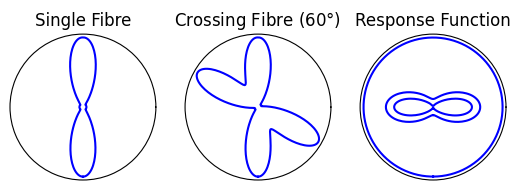

In [8]:
fig = plt.figure()

gridspec = fig.add_gridspec(nrows=1, ncols=3)
ax_single_fibre = fig.add_subplot(gridspec[0,0], projection='polar')
ax_crossing_fibre = fig.add_subplot(gridspec[0,1], projection='polar')
ax_response = fig.add_subplot(gridspec[0,2], projection='polar')

sh.plot_odf_on_axis(single_fibre, ax=ax_single_fibre)
sh.plot_odf_on_axis(crossing_60, ax=ax_crossing_fibre)
sh.plot_wmr_on_axis(sane_rf, bvals, ax=ax_response)

ax_single_fibre.set_title('Single Fibre')
ax_crossing_fibre.set_title(r'Crossing Fibre ($60\degree$)')
ax_response.set_title('Response Function')

## Simulation Functions
Functions to simulate a single voxel with a given fibre configuration and SNR. The function `add_noise` adds Rician noise to the signal. The function `run_msst_csd` estimates the ODF using MSMT-CSD. The function `run_simulation` simulates the voxel and estimates the ODF using LoRE-SD and MSMT-CSD.

In [9]:
def add_noise(noise_free, grad, snr):
    """
    Add Gaussian noise or Rician noise to a signal.

    Returns:
        numpy.ndarray: A signal with added Gaussian/Rician noise.
    """

    mean_b0 = np.mean(noise_free[..., np.where(grad[...,-1] == 0)[0]])

    std_noise = mean_b0 / snr
    noise1 = np.random.normal(0, std_noise, size=noise_free.shape)
    noise2 = np.random.normal(0, std_noise, size=noise_free.shape)
    noisy_dwi = np.sqrt((noise_free + noise1)**2 + noise2**2)

    return noisy_dwi

In [10]:
def get_msmt_csd_odf(voxel_dwi, response_function, grad):
    """
    Estimate the ODF using the MSMT-CSD algorithm.

    Args:
        voxel_dwi (numpy.ndarray): The DWI data for the voxel.
        response_function (numpy.ndarray): The response function.
        grad (numpy.ndarray): The gradient table.
        num_its (int): Number of iterations for the MSMT-CSD algorithm.

    Returns:
        numpy.ndarray: The estimated ODF.
    """

    assert voxel_dwi.ndim == 4, f'Data must have 4 dimensions. Actual: {voxel_dwi.ndim}'

    # Create a temporary directory
    tmp_dir = os.path.join(os.getcwd(), 'tmp')
    os.makedirs(tmp_dir, exist_ok=False)

    # Save the voxel data and response function
    save_mrtrix(os.path.join(tmp_dir, 'voxels.mif'), Image(voxel_dwi, grad=grad))
    varia.save_vector(os.path.join(tmp_dir, 'response.txt'), response_function)

    # Run the MSMT-CSD algorithm
    csd_cmd = [
        'dwi2fod', 'msmt_csd',
        os.path.join(tmp_dir, 'voxels.mif'),
        os.path.join(tmp_dir, 'response.txt'),
        os.path.join(tmp_dir, 'odf.mif'),
        '-force'
    ]
    subprocess.run(csd_cmd)

    # Load the estimated ODF
    est_odf = load_mrtrix(os.path.join(tmp_dir, 'odf.mif')).data

    # Remove the temporary directory, even if it is not empty
    shutil.rmtree(tmp_dir)

    return est_odf

### Simulation Variables

In [11]:
num_its_simulation = 500

snrs = [10, 20, 50, np.inf]

noise_free_single_fibre_voxel = sh.calcdwi(sh.sphconv(sane_rf, single_fibre), grad)
noise_free_single_fibre_dwi = np.repeat(noise_free_single_fibre_voxel[np.newaxis,...],
                                        num_its_simulation, axis=0).reshape((num_its_simulation, 1, 1, -1))


noise_free_crossing_60_voxel = sh.calcdwi(sh.sphconv(sane_rf, crossing_60), grad)
noise_free_crossing_60_dwi = np.repeat(noise_free_crossing_60_voxel[np.newaxis,...],
                                       num_its_simulation, axis=0).reshape((num_its_simulation, 1, 1, -1))

In [12]:
# Since this is a simulation, all voxels belong to the mask
mask = np.ones(noise_free_single_fibre_dwi.shape[:-1], dtype=bool)

# Simulations

In [13]:
# Empty dict in which we will store the results
simulation_dict = {}

In [14]:
for snr in snrs:
    for fibre_config, gt_odf, noise_free_dwi in zip(['Single Fibre', 'Crossing Fibre'], [single_fibre, crossing_60],
                                            [noise_free_single_fibre_dwi, noise_free_crossing_60_dwi]):
        noisy_dwi = add_noise(noise_free_dwi, grad, snr)
        lore_sd_out = optimise.get_signal_decomposition(noisy_dwi, mask, grad, axial_diffusivities,
                                                     radial_diffusivities, reg, lmax, cores=cores)
        est_odf = lore_sd_out['odf']
        est_rf = lore_sd_out['response']

        msmt_csd_odf = get_msmt_csd_odf(noisy_dwi, sane_rf, grad)

        lore_sd_acc = sh.angularCorrelation(est_odf, gt_odf)
        msmt_csd_acc = sh.angularCorrelation(msmt_csd_odf, gt_odf)

        simulation_dict[f'{fibre_config}_{snr}'] = {
            'LoRE-SD ODF': np.squeeze(est_odf),
            'MSMT-CSD ODF': np.squeeze(msmt_csd_odf),
            'LoRE-SD Response': np.squeeze(est_rf),
            'LoRE-SD ACC': np.squeeze(lore_sd_acc),
            'MSMT-CSD ACC': np.squeeze(msmt_csd_acc)
        }


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348368.81004230387
100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 46.20it/s]


Execution time: 00h 01m 08s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348369.08637981332
100%|█████████████████████████████████████████| 500/500 [00:13<00:00, 37.66it/s]


Execution time: 00h 00m 55s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348368.11757693341
100%|█████████████████████████████████████████| 500/500 [00:11<00:00, 42.17it/s]


Execution time: 00h 01m 03s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348368.49788341904
100%|█████████████████████████████████████████| 500/500 [00:13<00:00, 37.85it/s]


Execution time: 00h 01m 06s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348369.28869769408
100%|█████████████████████████████████████████| 500/500 [00:13<00:00, 36.03it/s]


Execution time: 00h 01m 08s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348367.93433336
100%|█████████████████████████████████████████| 500/500 [00:14<00:00, 35.49it/s]


Execution time: 00h 01m 08s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348368.48578869435
100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 28.49it/s]


Execution time: 00h 01m 10s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348369.13278639014
100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 47.64it/s]


Execution time: 00h 01m 05s


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/tmp/voxels.mif"
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K


In [15]:
from matplotlib.pyplot import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

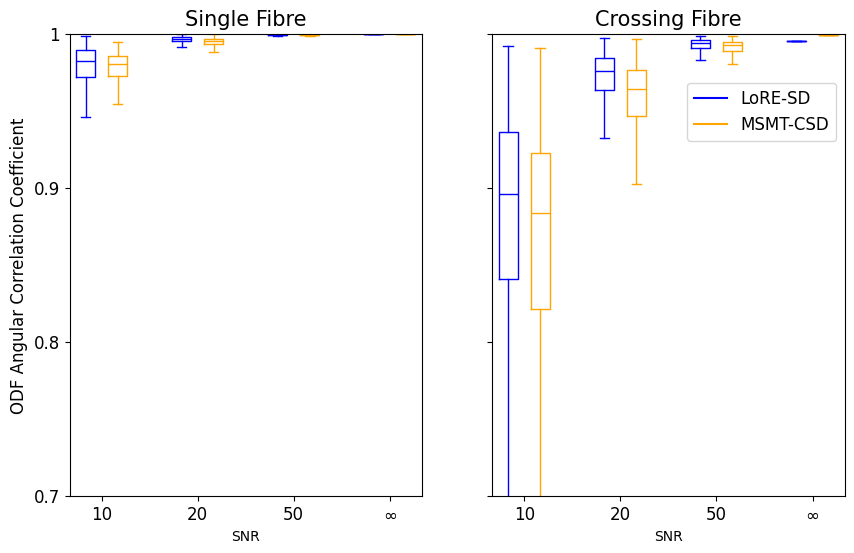

In [64]:
# Boxplots of the angular correlation coefficients
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
snrs = [10, 20, 50, np.inf]
snr_strings = ['10', '20', '50', r'$\infty$']

for fibre_config, ax in zip(['Single Fibre', 'Crossing Fibre'], axs.T):
    for i, snr in enumerate(snrs):
        key = f'{fibre_config}_{snr}'
        data_odf = simulation_dict[key]
        bp = ax.boxplot(
            [data_odf['LoRE-SD ACC'], data_odf['MSMT-CSD ACC']],
            positions=[1 + 3 * i, 2 + 3 * i],
            widths=0.6,
            showfliers=False
        )
        setBoxColors(bp)
    ax.set_xticks([1.5 + 3 * i for i in range(len(snrs))])
    ax.set_xticklabels(snr_strings, fontsize=12)
    ax.set_xlabel('SNR')
    ax.set_yticks([.7,.8,.9,1])
    ax.set_ylim([.7, 1])
    if ax != axs.T[0]:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels([.7,.8,.9,1], fontsize=12)
    ax.set_title(fibre_config, fontsize=15)

axs[0].set_ylabel('ODF Angular Correlation Coefficient', fontsize=12)

# draw temporary red and blue lines and use them to create a legend
hB, = axs[-1].plot(5, 1,'-', color='blue', label='hB')
hR, = axs[-1].plot(5, 1,'-', color='orange', label='hR')
patches, _ = axs[-1].get_legend_handles_labels()
fig.legend(patches, ['LoRE-SD', 'MSMT-CSD'], fontsize=12, loc='center right', bbox_to_anchor=(.9, .75), frameon=True)
hB.set_visible(False)
hR.set_visible(False)

plt.savefig('/LOCALDATA/sleyse4/boxplots_voxel.png', dpi=300, transparent=True)

plt.show()


# Plot the variance within the response function estimations
For every configuration, the variance within the response function estimations is plotted. The variance is calculated for each shell of the response function. The variance is visualized by filling the area between the minimum and maximum values of the response function estimations.

In [65]:
def fill_kernels(kernels, ax, color):
    # Calculate the maximum degree of spherical harmonics
    lmax = (kernels[0].shape[-1]-1)*2

    # Get the number of shells in the kernel
    num_shells = len(kernels[0])

    # Generate a modified spherical harmonics basis
    Q_k = sh.modshbasis(lmax, np.linspace(0, 2*np.pi, 400), np.zeros(400))

    # Initialize indices for spherical harmonics
    idx = []
    end = 0
    for l in range(0, lmax + 1, 2):
        idx.append(end + (2 * l + 1) // 2)
        end += 2 * l + 1

    # Select the required columns from the basis
    Q_k = Q_k[:,idx]

    # Convert kernels to polar coordinates
    kernels_polar = [kernel @ Q_k.T for kernel in kernels]
    kernels_polar = np.asarray(kernels_polar)

    # Define angles for plotting
    angles = np.linspace(0, 2*np.pi, 400)
    # Plot each shell
    for i in range(num_shells):
        minima = np.squeeze(np.amin(kernels_polar[:,i,:], axis=0))
        maxima = np.squeeze(np.amax(kernels_polar[:,i,:], axis=0))

        # Fill between minima and maxima for each shell
        ax.fill_between(angles - np.pi / 2, minima, maxima, alpha=.2, color=color, edgecolor=(0,0,0,0), linewidth=0)

        # Set xticks if axis is provided
        xlocs = np.arange(0, 2 * np.pi, np.pi / 4)
        ax.set_xticks(xlocs, [''] * len(xlocs))


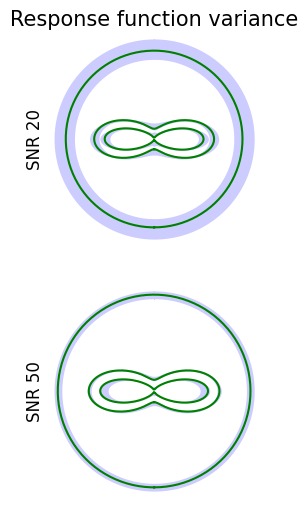

In [66]:
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 6))
gs = gridspec.GridSpec(2,1, figure=fig)

# Subplot for Crossing Fibre SNR 20
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
fill_kernels(simulation_dict['Crossing Fibre_20']['LoRE-SD Response'], ax1, 'blue')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel(f'SNR {20}', fontsize=12)
sh.plot_wmr_on_axis(sane_rf, bvals, ax1, c='green')
ax1.set_title('Response function variance', fontsize=15)
ax1.spines['polar'].set_visible(False)

# Subplot for Crossing Fibre SNR 50
ax2 = fig.add_subplot(gs[1,0], projection='polar')
fill_kernels(simulation_dict['Crossing Fibre_50']['LoRE-SD Response'], ax2, 'blue')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel(f'SNR {50}', fontsize=12)
sh.plot_wmr_on_axis(sane_rf, bvals, ax2, c='green')
ax2.spines['polar'].set_visible(False)

plt.savefig('/LOCALDATA/sleyse4/response_variance.png', dpi=300, transparent=True)

plt.show()

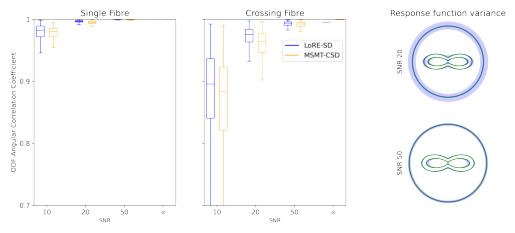

In [69]:
# Load the boxplots image
import matplotlib.image as mpimg
bp_img = mpimg.imread('/LOCALDATA/sleyse4/boxplots_voxel.png')
# Load the response variance image
rv_img = mpimg.imread('/LOCALDATA/sleyse4/response_variance.png')

assert bp_img.shape[0] == rv_img.shape[0], 'Images must have the same height'

padding_width = 0

padding = np.ones((bp_img.shape[0], padding_width, 4), dtype=np.uint8)

# Create a new image with the boxplots and response variance images
stitched_img = np.concatenate((bp_img, padding, rv_img), axis=1)

# show the bp_img
plt.axis('off')

left_white = np.where(np.any(stitched_img[...,-1] != 0, axis=0))[0][0]-5
right_white = np.where(np.any(stitched_img[...,-1] != 0, axis=0))[0][-1]+5
top_white = np.where(np.any(stitched_img[...,-1] != 0, axis=1))[0][0]-5
bottom_white = np.where(np.any(stitched_img[...,-1] != 0, axis=1))[0][-1]+5

# Save the stitched image
mpimg.imsave('/LOCALDATA/sleyse4/combined_img_voxel_sim.png', stitched_img[top_white:bottom_white, left_white:right_white])

plt.imshow(stitched_img[top_white:bottom_white, left_white:right_white])